In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import dataset.transform as tfm
import dataset.assemble as asm
import keras
import pickle
import pandas as pd
from plot_utils import show_some, image_grid
import cv2 as cv
import numpy as np
from pathlib import Path
import ipywidgets as wgt

Using TensorFlow backend.


In [3]:
BASEPATH = Path('/data/staff/common/ML-crystals')

In [4]:

def img_on_point(rawimg, point, shape):
    pass


def grid(origin, distance, shape):
    '''
    origin: (x, y)
    '''
    return [
        (origin[0] + distance * i, origin[1] + distance * j)
        for i in range(shape[0]) for j in range(shape[1])
    ]


def center_of(img):
    return tuple(img.shape[a] // 2 for a in [1, 0])


def prep_img(img, center_on=None, crop_radius=None):
    # TODO cropping
    if not center_on:
        center_on = center_of(img)
    cx, cy = center_on
    imrad = min(cx, cy, img.shape[0] - cy, img.shape[1] - cx)
    if crop_radius and crop_radius < imrad:
        imrad = crop_radius
    img = img[cy - imrad : cy + imrad, cx - imrad : cx + imrad]
    return cv.resize(img, (128, 128))


def create_heatmap(img, model, origo, mapshape, spacing):

    points = grid(origo, spacing, mapshape)
    x = np.stack([prep_img(img, center_on=p) for p in points])
    yp = model.predict(x).reshape(-1)
    return points, yp


def draw_heatmap(img, points, yp, ax=None, **kwargs):
    if ax is None:
        ax = plt
    ax.imshow(img, cmap='gray')
    px, py = tuple([point[d] for point in points] for d in [0, 1])
    ax.scatter(px, py, c=yp, **kwargs)

In [5]:
!ls /data/staff/common/ML-crystals/models/report/tanh_and_regress/

a10.hdf5  a2.hdf5  a4.hdf5  a6.hdf5  a8.hdf5
a1.hdf5   a3.hdf5  a5.hdf5  a7.hdf5  a9.hdf5


In [5]:
df = asm.get_dataset_df('/data/staff/common/ML-crystals/csv/all_0.5.csv')

loading meta files
meta loaded


In [6]:
raws = df['filename'].sample(n=20).apply(lambda x: cv.imread(x, cv.IMREAD_GRAYSCALE))

In [7]:
titles = df.loc[list(raws.index)]['sample'] + '__' + df.loc[list(raws.index)]['scan']

In [ ]:
image_grid(list(raws),titles=list(titles))

In [8]:
SMPNAME = 'Sample-1-02'
HARVEST = 1
SMPIDX  = 118

#fn1 = df[(df['sample'] == 'Sample-3-02') & (df['scan']=='20180479_2')]['filename'].iloc[50]
#fn1 = df[(df['sample'] == 'Sample-3-01')]['filename'].iloc[-50]
#fn1 = df[(df['sample'] == 'Sample-4-01')]['filename'].iloc[-50]
target_df = df[
    (df['sample'] == SMPNAME) &
    (df['scan'].apply(lambda x: x.startswith('2018' if HARVEST == 2 else 'local')))
]


In [9]:
fnex = [0, 0]
def show_rawimg(fn, v, i):
    v[0] = fn
    v[1] = i
    print(v[0])
    plt.imshow(cv.imread(fn, cv.IMREAD_GRAYSCALE))
wgt.interact(lambda i: show_rawimg(target_df['filename'].iloc[i], fnex, i), i=(0, len(target_df)))
# fn1 = df[(df['sample'] == 'Sample-4-11')]['filename'].iloc[-50]


interactive(children=(IntSlider(value=100, description='i', max=200), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(i)>

In [10]:
fn1 = fnex[0]
SMPIDX = fnex[1]

In [11]:
fn1

'/data/visitors/biomax/20180479/20181119/raw/Sample-1-02/timed_snapshots/local-user_4_1542644562.92.jpeg'

In [12]:
raw1 = cv.imread(fn1, cv.IMREAD_GRAYSCALE)
im1 = (raw1 - np.mean(raw1)) / np.std(raw1)
cx, cy = center_of(im1)
g = grid((128,128), 16, (64,48))
conf = dict(input_shape=(128,128,1))
gims = [
    prep_img(im1, center_on=(gx,gy), crop_radius=128)
    for gx, gy in g
]

gdf = pd.DataFrame({
    'img':gims,
#     'px':[p[0] for p in g],
#     'py':[p[1] for p in g],
    'point': g,
    'y':[0]*len(g)}
)
gdf = tfm.aug_hflip(gdf)
gdf = tfm.aug_rotate(gdf, conf)
gx, gy = asm.df_to_xy(gdf, conf)
#image_grid(gims, titles=g)
cx,cy

 26%|██▌       | 784/3072 [00:00<00:00, 7836.70it/s]

flip augmentation


100%|██████████| 3072/3072 [00:00<00:00, 7833.53it/s]


rotate augmentation


(680, 512)

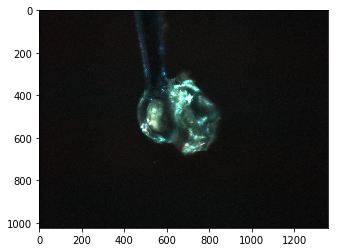

In [13]:
plt.imshow(cv.imread(fn1), cmap='gray')

In [14]:
md = keras.models.load_model(
    '/data/staff/common/ML-crystals/models/report/tanh_and_regress/a3.hdf5'
)

In [ ]:
md.summary()

In [15]:
SHORTSTRAT='tanh'
STRATEGY = 'tanh_and_regress'
model_paths = list((BASEPATH / 'models' / 'report' / STRATEGY).iterdir())
model_paths.sort(key=lambda x: int(x.stem[1:]))
model_paths

[PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a1.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a2.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a3.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a4.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a5.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a6.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a7.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a8.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a9.hdf5'),
 PosixPath('/data/staff/common/ML-crystals/models/report/tanh_and_regress/a10.hdf5')]

/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a1.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a2.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a3.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a4.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a5.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a6.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a7.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a8.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a9.png
/data/staff/common/ML-crystals/heatmaps/Sample-1-02-100/tanh_and_regress/a10.png


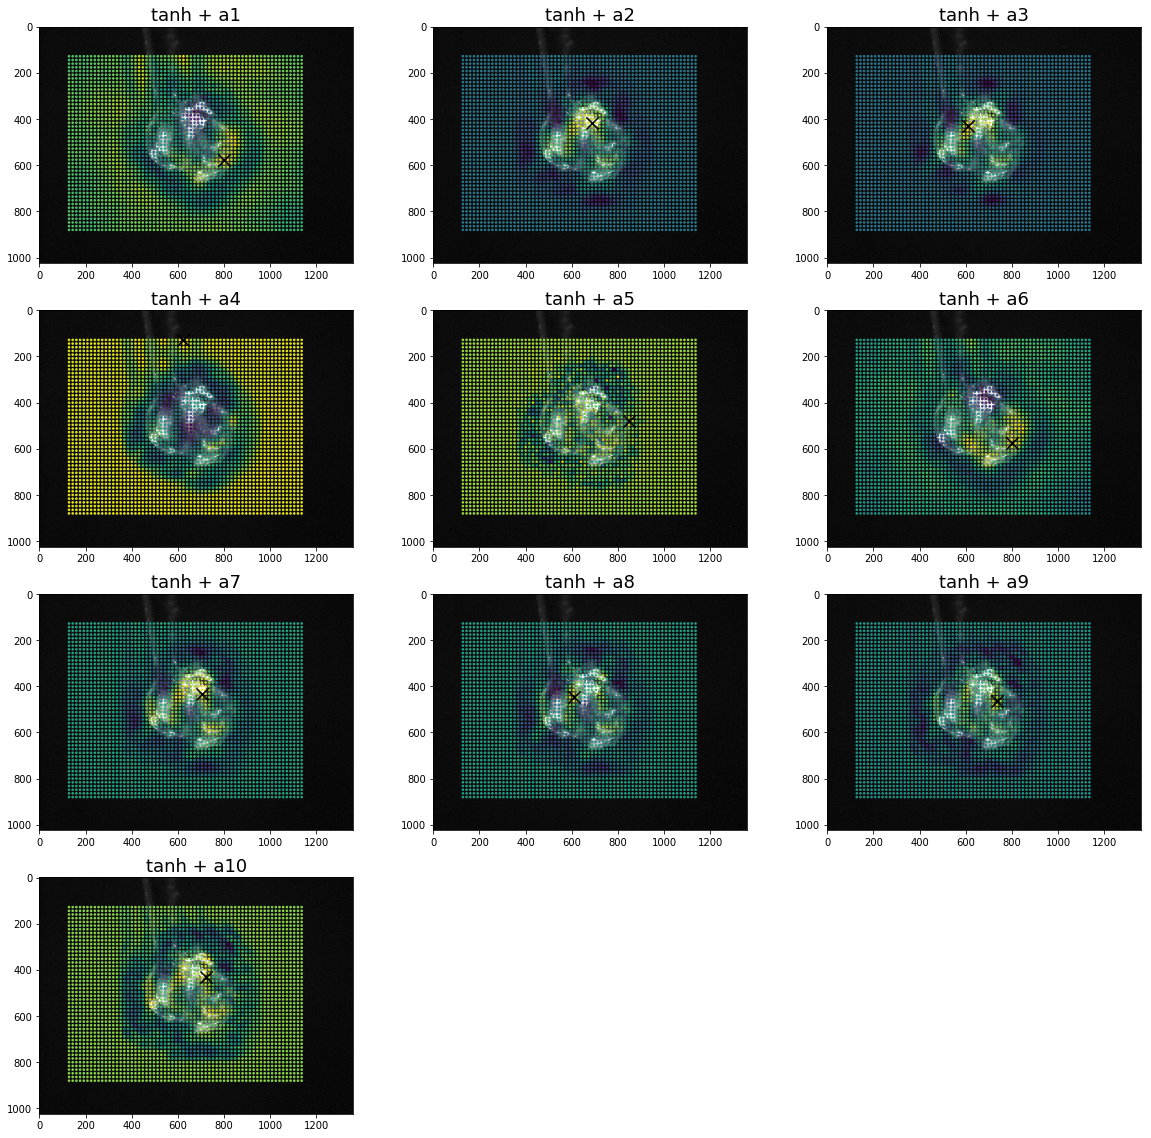

In [16]:

fig = plt.figure(figsize=(20,20))
for midx, p in enumerate(model_paths):
    ax = fig.add_subplot(len(model_paths)//3+1, 3, midx+1)
    ax.set_title(f'{SHORTSTRAT} + {p.stem}', fontsize=18)
    figpath = BASEPATH / 'heatmaps' / f'{SMPNAME}-{SMPIDX}' / p.parent.stem / f'{p.stem}.png'
    if not figpath.parent.is_dir():
        figpath.parent.mkdir(parents=True)
    print(figpath)
    md = keras.models.load_model(str(p))
    gdf['pred'] = md.predict(gx)
    mgdf = gdf.groupby('point').min()
    draw_heatmap(im1, g, mgdf['pred'], marker='.', s=10)

    highs = list(mgdf.sort_values('pred', ascending=False).iloc[:1].index)
    lows = list(mgdf.sort_values('pred', ascending=True).iloc[:1].index)
    high_center = tuple(np.mean(a) for a in zip(*highs))
    low_center = tuple(np.mean(a) for a in zip(*lows))
    ax.scatter([high_center[0]], [high_center[1]], marker='x', color='black', s=150)
#     ax.scatter([low_center[0]], [low_center[1]], marker='o', color='blue')
#     plt.savefig(
#         fname=f'/data/staff/common/ML-crystals/heatmaps/log/{p.stem}.png',
#         format='png',
#     )
    del md
fig.show()

In [ ]:
p = Path('/data/staff/common/ML-crystals/models/report/tanh_and_regress/')

In [ ]:
p.iterdir()

In [ ]:
'abc'.startswith('a')

In [ ]:
df['scan'].apply(lambda x: x.startswith('local'))